In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.core import Activation, Dropout
from math import sqrt
from matplotlib import pyplot
import numpy as np
import pandas as pd

C:\ProgramData\Anaconda3\envs\tensorflow35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Hardcode all variables
batch_size_exp = 1
epoch_exp = 7
neurons_exp = 5
predict_values_exp = 2
lag_exp=24

In [3]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [4]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [5]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [6]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [7]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [8]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [9]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    #print(X)
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]

In [10]:
''' Loading data '''
import pandas as pd
series = pd.read_excel('AL_WIND_07_12.xlsx',index_col="DateTime")
series.head()

,Air temperature | ('C),Pressure | (atm),Wind speed | (m/s),Wind direction | (deg),Power generated by system | (kW)
DateTime,,,,,
2007-01-01 00:00:00,10.926,0.979103,9.014,229,33688.1
2007-01-01 01:00:00,9.919,0.979566,9.428,232,37261.9
2007-01-01 02:00:00,8.567,0.979937,8.700,236,30502.9
2007-01-01 03:00:00,7.877,0.980053,8.481,247,28419.2
2007-01-01 04:00:00,7.259,0.979867,8.383,256,27370.3


In [11]:
#replacing zeros with median power generated
median_power_generated = series['Power generated by system | (kW)'].median()
series["Power generated by system | (kW)"] = np.where(series["Power generated by system | (kW)"] == 0, median_power_generated,series['Power generated by system | (kW)'])
series.tail()

,Air temperature | ('C),Pressure | (atm),Wind speed | (m/s),Wind direction | (deg),Power generated by system | (kW)
DateTime,,,,,
2012-12-31 19:00:00,3.306,0.994371,2.089,15,7286.3
2012-12-31 20:00:00,3.674,0.994060,1.785,23,7286.3
2012-12-31 21:00:00,3.015,0.993726,1.590,35,7286.3
2012-12-31 22:00:00,-0.317,0.993483,2.012,45,7286.3
2012-12-31 23:00:00,-1.048,0.993414,2.132,39,7286.3


In [12]:
'''Drop all the features as we will not be having any in production'''
del series['Air temperature | (\'C)']
del series['Pressure | (atm)']
del series['Wind direction | (deg)']
del series['Wind speed | (m/s)']
series.head()

,Power generated by system | (kW)
DateTime,
2007-01-01 00:00:00,33688.1
2007-01-01 01:00:00,37261.9
2007-01-01 02:00:00,30502.9
2007-01-01 03:00:00,28419.2
2007-01-01 04:00:00,27370.3


In [13]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [14]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

In [15]:
# split data into train and test-sets
train, test = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]

In [16]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

C:\ProgramData\Anaconda3\envs\tensorflow35\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [17]:
# fit the model
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)

Epoch 1/1
52557/52557 [==============================] - 148s 3ms/step - loss: 0.0147
Epoch 1/1
52557/52557 [==============================] - 146s 3ms/step - loss: 0.0145
Epoch 1/1
52557/52557 [==============================] - 136s 3ms/step - loss: 0.0144
Epoch 1/1
52557/52557 [==============================] - 152s 3ms/step - loss: 0.0143
Epoch 1/1
52557/52557 [==============================] - 152s 3ms/step - loss: 0.0141
Epoch 1/1
52557/52557 [==============================] - 151s 3ms/step - loss: 0.0141
Epoch 1/1
52557/52557 [==============================] - 121s 2ms/step - loss: 0.0140


In [18]:
# walk-forward validation on the test data
predictions = list()
expectations = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    #print(test_scaled)
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    #print(X)
    yhat = forecast_lstm(lstm_model, 1, X)#batch_size_exp to 1
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    expectations.append(expected)
    print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Hour=1, Predicted=9045.189957, Expected=7286.300000
Hour=2, Predicted=7713.820938, Expected=7286.300000


In [19]:
# Evaluate performance
expectations = np.array(expectations)
predictions = np.array(predictions)
print("Mean Percent Error: ",(np.mean(np.abs((expectations - predictions) / expectations))*100))

Mean Percent Error:  15.003574485237767


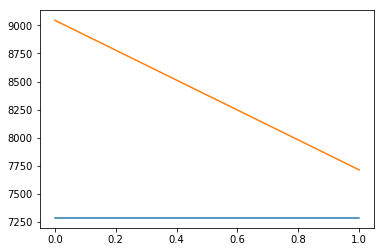

In [20]:
# line plot of observed vs predicted
pyplot.plot(raw_values[-predict_values_exp:])
pyplot.plot(predictions)
pyplot.show()